# Workspace \#8: Parameter Space

In [1]:
# %load firstcell.py
# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# getting future division
from __future__ import division

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [2]:
from random import random, choice

import sys
sys.path.insert(0, '../')

import constants as ct
import particle as pt
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md

/home/chen/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# Important quantities for aberration estimate
solar_period = 2.4e8 # [years]
solar_mw_radius = ct._Sun_to_gal_center_ # [kpc]

## 1. $(t_{\rm age}, D)$

### 1.1 Analytic formulas

/home/chen/Code/axion_laser/github/workspace_notebooks/plots/param_space/sample_alpha-0.6_S0-42.0_ma-3.0e-06.pdf


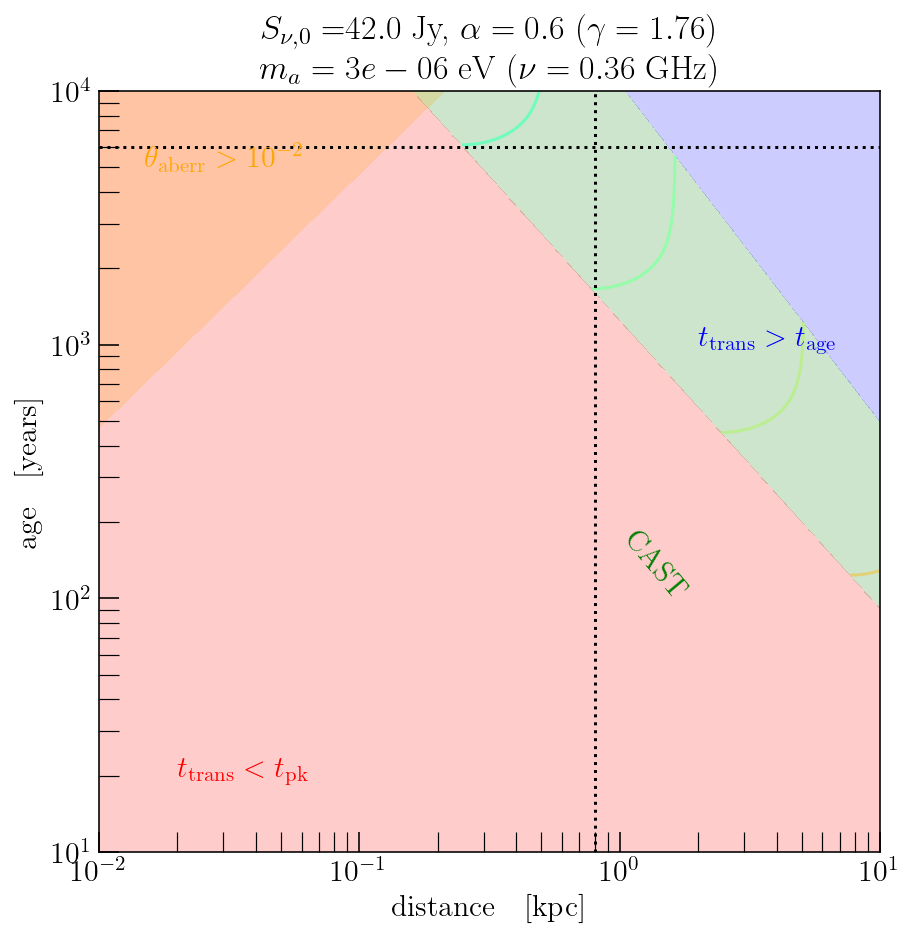

In [9]:
title_sz = 17.
label_sz = 15.
legend_sz = 15.

rcParams['figure.figsize'] = (7, 7)

fig, ax = plt.subplots()

maskQ = True

# signal-to-noise ratio we are interested in
snr_val = 2.

# spectral and adiabatic indices
alpha = .6
gamma = ap.gamma_from_alpha(alpha)

# energetics
nu_pivot = 1. # [GHz]

ga_ref = 1.e-10 # [GeV^-1]
ma_ref = 3.e-6 # [eV]
nu_ref = pt.nu_from_ma(ma_ref) # [GHz]
# SKA specs
exper_mode = ap.SKA_exper_nu(nu_ref)
area, window, Tr, Omega_res = ap.SKA_specs(nu_ref, exper_mode)

ga_cast = 6.e-11 # [GeV^-1]

deltaE_over_E = 1.e-3
delta_nu = nu_ref*deltaE_over_E # [GHz]

# source evolution and properties
S0 = 42.# [Jy] # spectral irrad. today at 1GHz
# S0 *= (nu_ref/nu_pivot)**-alpha # multiplying by the nu-dependence, in case the S0 given is for nu=nu_pivot but nu_ref != nu_pivot

# SNR early-time evolution: from Bietenholz et al., Table 4.
# All
muLt, sigLt, Nst = 1.7, 0.9, -1. # mean, std., #std.: log(t_peak/days)
muLL, sigLL, NsL = 25.5, 1.5, 2. # mean, std., #std.: log(L_peak/c.g.s.)

tpk = 10.**(muLt + Nst*sigLt) # [days]
Lpk = 10.**(muLL + NsL*sigLL) # [erg * s^-1 * Hz^-1]

# specific
tpk = 570.
Lpk = 6.4e27

##########
# ARRAYS #
##########

# t_age and dist arrays
max_age = 1.e4 # [years]
Nsteps  = 501
tage_arr = np.logspace(1., log10(max_age), Nsteps)
dist_arr = np.logspace(-2., 1., Nsteps)

# distance and age grids
dist_Gr, tage_Gr = np.meshgrid(dist_arr, tage_arr, indexing='xy')
area_Gr = 4.*pi*(dist_Gr*ct._kpc_over_cm_)**2. # [cm^2]
Spk_Gr = Lpk/area_Gr/ct._Jy_over_cgs_irrad_ # [Jy]
sup_Gr = S0/Spk_Gr

# fractional t_tpk and t_trans
ftpk_Gr = tpk/365./tage_Gr
ftt_Gr = ap.ftt(gamma, ftpk_Gr, sup_Gr)
tt_Gr = tage_Gr*ftt_Gr

# S_echo grid
Se_Gr = ec.echo_an_sup(ma_ref, ga_ref, Lpk, dist_Gr, S0, tage_Gr, gamma, tpk, deltaE_over_E=deltaE_over_E)
Se_Gr *= (nu_ref/nu_pivot)**-alpha

# snr grid
snr_Gr = ec.snr_fn(Se_Gr, nu_ref, delta_nu, Tbg_408=ec.Tbg_408_avg, fDelta=0.721, tobs=100.)
ga_Gr = ec.ga_reach(snr_val, snr_Gr, ga_ref)

# aberration grid
ab_Gr = (2.*pi*tage_Gr/solar_period)*(solar_mw_radius/dist_Gr)
aber_lim = 1.e-2 # limit to the aberration

############
# Plotting #
############

title = r"$S_{\nu, 0}=$"+r"${{{}}}$ Jy, ".format(S0)+r"$\alpha = {{{}}}$ ".format(alpha)+"($\gamma = {{{:.2f}}}$)".format(ap.gamma_from_alpha(alpha))+"\n"+r"$m_a = {{{:.2}}}$ eV ".format(ma_ref)+r"($\nu = {{{:.2}}}$ GHz)".format(nu_ref)

name = current_dir+"/plots/param_space/sample_alpha-{}_S0-{:.1f}_ma-{:.1e}.pdf".format(alpha, S0, ma_ref).replace(" ", "")


# snr levels
ga_min, ga_max = np.floor(log10(np.abs(ga_Gr).min())), np.ceil(log10(ga_Gr.max()))
# ga_lvls = [-13, log10(2), log10(5), 1.]
ga_lvls = np.arange(-13, -6, 0.5)

# plotting ga_reach

if maskQ:
    
    peak_mask = (ftt_Gr/ftpk_Gr <= 1.)
    trans_mask = (log10(ftt_Gr) >= 0.)
    sup_mask = (log10(sup_Gr) >= 0.)
    
    total_mask = np.logical_or(peak_mask, trans_mask)
    total_mask = np.logical_or(total_mask, sup_mask)
    
    ga_Gr_masked = np.ma.masked_array(ga_Gr, total_mask)
    
    cs_ga = ax.contour(dist_arr, tage_arr, log10(ga_Gr_masked), levels=ga_lvls, cmap="rainbow")
    ax.contourf(dist_arr, tage_arr, log10(ga_Gr_masked), levels=[log10(ga_cast), 100.], colors=['g'], alpha=0.2, zorder=-1)
    
#     for lvl in cs_ga._levels:
#         plt.clabel(cs_ga, [lvl], fmt=r"$g_a = 10^{{{}}}$".format(lvl)+r" $\mathrm{GeV}^{-1}$", inline=True, inline_spacing=30.)

else:
    cs_ga = ax.contour(dist_arr, tage_arr, log10(ga_Gr), levels=ga_lvls, cmap="rainbow")
    ax.contourf(dist_arr, tage_arr, log10(ga_Gr), levels=[log10(ga_cast), 100.], colors=['g'], alpha=0.2, zorder=-1)

# non-sensical regions
ax.contourf(dist_arr, tage_arr, ftt_Gr/ftpk_Gr, levels=[-1.e4, 1.], colors=['r'], alpha=0.2, zorder=-1)
ax.contourf(dist_arr, tage_arr, log10(ftt_Gr), levels=[0., 100.], colors=['b'], alpha=0.2, zorder=-1)
ax.contourf(dist_arr, tage_arr, log10(sup_Gr), levels=[0., 100.], colors=['k'], alpha=0.2, zorder=-1)
ax.contourf(dist_arr, tage_arr, log10(ab_Gr), levels=[log10(aber_lim), 100.], colors=['orange'], alpha=0.2, zorder=-1)


# plt.axhline(tpk/365., ls=':', lw=4., color='r')

# x- and y-scales
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlabel(r"distance$\quad[\mathrm{kpc}]$", fontsize=label_sz);
ax.set_ylabel(r"age$\quad[\mathrm{years}]$", fontsize=label_sz);
ax.set_title(title, fontsize=title_sz);
ax.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.)

ax.text(0.02, 20., r"$t_{\rm trans} < t_{\rm pk}$", color="r", fontsize=legend_sz);
ax.text(2., 1000., r"$t_{\rm trans} > t_{\rm age}$", color="b", fontsize=legend_sz);
ax.text(1., 100., r"CAST", rotation=-50., color="g", fontsize=legend_sz);
ax.text(0.015, 5.e3, r"$\theta_{\rm aberr} > 10$"+r"$^{{{}}}$".format(int(log10(aber_lim))), color="orange", fontsize=legend_sz)

ax.axhline(6000., ls=':', c='k')
ax.axvline(0.8, ls=':', c='k')


del snr_val, alpha, gamma, nu_pivot, ga_ref, ga_cast, ma_ref, nu_ref, max_age, Nsteps, tage_arr, dist_arr, dist_Gr, tage_Gr, area_Gr, Spk_Gr, sup_Gr, ftpk_Gr, ftt_Gr, tt_Gr, Se_Gr, snr_Gr, ga_Gr, title, ga_min, ga_max, ga_lvls, peak_mask, trans_mask, sup_mask, total_mask, ga_Gr_masked, cs_ga

print(name)
# plt.savefig(name, bbox_inches="tight")

### 1.2 Numerical formulas

100%|██████████| 21/21 [01:10<00:00,  3.38s/it]
<ipython-input-10-ef7c89dfc746>:175: UserWarning: No contour levels were found within the data range.
  cs_ga = ax.contour(dist_arr, tage_arr, log10(ga_Gr_masked), levels=ga_lvls, cmap="rainbow")


/home/chen/Code/axion_laser/github/workspace_notebooks/plots/param_space/sample_alpha-0.6_S0-42.0_ma-3.0e-06.pdf


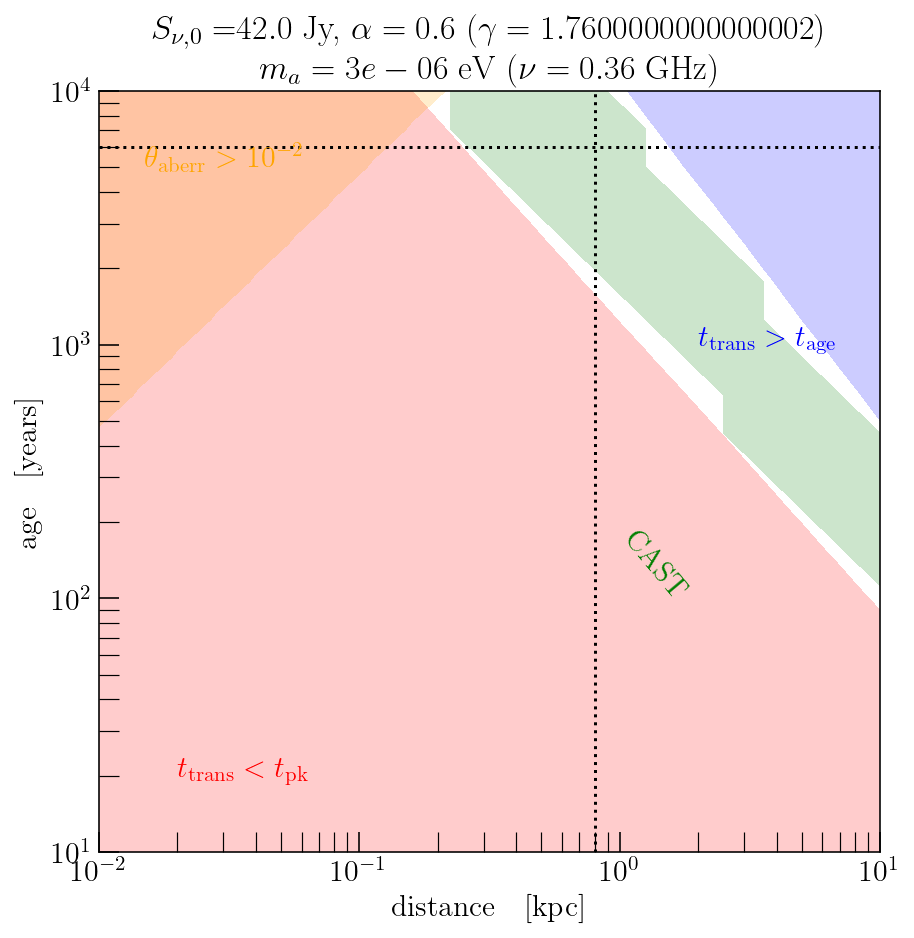

In [10]:
title_sz = 17.
label_sz = 15.
legend_sz = 15.

rcParams['figure.figsize'] = (7, 7)

fig, ax = plt.subplots()

maskQ = True

# signal-to-noise ratio we are interested in
snr_val = 2.

# spectral and adiabatic indices
alpha = .6
gamma = ap.gamma_from_alpha(alpha)

# energetics
nu_pivot = 1. # [GHz]
ma_ref = pt.ma_from_nu(nu_pivot) # [eV]
ga_ref = 1.e-10 # [GeV^-1]

ga_new = ga_ref # [GeV^-1]
ma_new = 3.e-6 # [eV]
nu_new = pt.nu_from_ma(ma_new) # [GHz]
# SKA specs
exper_mode = ap.SKA_exper_nu(nu_new)
area, window, Tr, Omega_res = ap.SKA_specs(nu_new, exper_mode)

ga_cast = 6.e-11 # [GeV^-1]

deltaE_over_E = 1.e-3
delta_nu = nu_new*deltaE_over_E # [GHz]

# source evolution and properties
S0 = 42.# [Jy] # spectral irrad. today at 1GHz
# S0 *= (nu_ref/nu_pivot)**-alpha # multiplying by the nu-dependence, in case the S0 given is for nu=nu_pivot but nu_ref != nu_pivot

# SNR early-time evolution: from Bietenholz et al., Table 4.
# All
muLt, sigLt, Nst = 1.7, 0.9, -1. # mean, std., #std.: log(t_peak/days)
muLL, sigLL, NsL = 25.5, 1.5, 2. # mean, std., #std.: log(L_peak/c.g.s.)

tpk = 10.**(muLt + Nst*sigLt) # [days]
Lpk = 10.**(muLL + NsL*sigLL) # [erg * s^-1 * Hz^-1]

# specific
tpk = 570.
Lpk = 6.4e27

##########
# ARRAYS #
##########

# t_age and dist arrays
max_age = 1.e4 # [years]
# Nsteps  = 101 # fine grid
Nsteps  = 21 # coarse grid
tage_arr = np.logspace(1., log10(max_age), Nsteps)
dist_arr = np.logspace(-2., 1., Nsteps)
dist_Gr, tage_Gr = np.meshgrid(dist_arr, tage_arr, indexing='xy')

source_input = {'longitude':0.,
                'latitude':0.,
                'distance':1., # placeholder
                'size':(4.*pi),
                't_age':1000.,# placeholder
                'alpha':alpha,
                'nu_pivot':1.,
                'gamma':gamma,
                'model':'eff', 'L_today':1.e-25, 'L_peak':Lpk,
#                 'model':'eff', 'L_today':LumCasA, 't_trans':10.,
                't_peak':tpk
               }

axion_input = rt.ax_in(ma_new, ga_new)

data = {'deltaE_over_E':1.e-3,
        'f_Delta':0.721,
        'exper':'SKA',
        'total_observing_time':100.,
        'average':True,
        'verbose':0
       }

Snu_echo_kwargs = {'tmin_default':None,
                   'Nt':10001,
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*(1000.)+1),
                   't_extra_old':0.}

snr_Gr = []
ftt_Gr = []
sup_Gr = []
ftpk_Gr = []

for t_age in tqdm(tage_arr):
    row = []
    row_ftt = []
    row_sup = []
    row_ftpk = []
    for dist in dist_arr:
        
        area = 4.*pi*(dist*ct._kpc_over_cm_)**2. # [cm^2]
        Spk = Lpk/area/ct._Jy_over_cgs_irrad_ # [Jy]
        sup = S0/Spk
        L0 = Lpk*sup
        
#         # fractional t_tpk and t_trans
        ftpk = tpk/365./t_age
        ftt = ap.ftt(gamma, ftpk, sup)
        tt = t_age*ftt
        
        source_input.update({'t_age':t_age, 'distance':dist, 'L_today':L0})
        Snu_echo_kwargs.update({'Nint':int(30*(t_age)+1)})
        
        routine_out = {}
        bounds_out = rt.full_routine(ma_new, ga_new, ga_ref, routine_out,
                                     source_input=source_input,
                                     data=data,
                                     Snu_echo_kwargs=Snu_echo_kwargs)
        
        row.append(bounds_out['S/N'])
        row_ftt.append(ftt)
        row_sup.append(sup)
        row_ftpk.append(ftpk)
        
    snr_Gr.append(row)
    ftt_Gr.append(row_ftt)
    sup_Gr.append(row_sup)
    ftpk_Gr.append(row_ftpk)

# converting to arrays:
snr_Gr = np.array(snr_Gr)
ftt_Gr = np.array(ftt_Gr)
sup_Gr = np.array(sup_Gr)
ftpk_Gr = np.array(ftpk_Gr)

# reach grid
ga_Gr = ec.ga_reach(snr_val, snr_Gr, ga_ref)

# aberration grid
ab_Gr = (2.*pi*tage_Gr/solar_period)*(solar_mw_radius/dist_Gr)
aber_lim = 1.e-2 # limit to the aberration

############
# Plotting #
############

title = r"$S_{\nu, 0}=$"+r"${{{}}}$ Jy, ".format(S0)+r"$\alpha = {{{}}}$ ".format(alpha)+"($\gamma = {{{}}}$)".format(ap.gamma_from_alpha(alpha))+"\n"+r"$m_a = {{{:.2}}}$ eV ".format(ma_new)+r"($\nu = {{{:.2}}}$ GHz)".format(nu_new)

name = current_dir+"/plots/param_space/sample_alpha-{}_S0-{:.1f}_ma-{:.1e}.pdf".format(alpha, S0, ma_new).replace(" ", "")

# snr levels
ga_min, ga_max = np.floor(log10(np.abs(ga_Gr).min())), np.ceil(log10(ga_Gr.max()))
# ga_lvls = [-13, log10(2), log10(5), 1.]
ga_lvls = np.arange(-13, -6, 0.5)

# plotting ga_reach

if maskQ:
    
    peak_mask = (ftt_Gr/ftpk_Gr <= 1.)
    trans_mask = (log10(ftt_Gr) >= 0.)
    sup_mask = (log10(sup_Gr) >= 0.)
    
    total_mask = np.logical_or(peak_mask, trans_mask)
    total_mask = np.logical_or(total_mask, sup_mask)
    
    ga_Gr_masked = np.ma.masked_array(ga_Gr, total_mask)
    
    cs_ga = ax.contour(dist_arr, tage_arr, log10(ga_Gr_masked), levels=ga_lvls, cmap="rainbow")
    ax.contourf(dist_arr, tage_arr, log10(ga_Gr_masked), levels=[log10(ga_cast), 100.], colors=['g'], alpha=0.2, zorder=-1)
    
#     for lvl in cs_ga._levels:
#         plt.clabel(cs_ga, [lvl], fmt=r"$g_a = 10^{{{}}}$".format(lvl)+r" $\mathrm{GeV}^{-1}$", inline=True, inline_spacing=30.)

else:
    cs_ga = ax.contour(dist_arr, tage_arr, log10(ga_Gr), levels=ga_lvls, cmap="rainbow")
    ax.contourf(dist_arr, tage_arr, log10(ga_Gr), levels=[log10(ga_cast), 100.], colors=['g'], alpha=0.2, zorder=-1)

# non-sensical regions
ax.contourf(dist_arr, tage_arr, ftt_Gr/ftpk_Gr, levels=[-1.e4, 1.], colors=['r'], alpha=0.2, zorder=-1)
ax.contourf(dist_arr, tage_arr, log10(ftt_Gr), levels=[0., 100.], colors=['b'], alpha=0.2, zorder=-1)
ax.contourf(dist_arr, tage_arr, log10(sup_Gr), levels=[0., 100.], colors=['k'], alpha=0.2, zorder=-1)
ax.contourf(dist_arr, tage_arr, log10(ab_Gr), levels=[log10(aber_lim), 100.], colors=['orange'], alpha=0.2, zorder=-1)


# plt.axhline(tpk/365., ls=':', lw=4., color='r')

# x- and y-scales
ax.set_xscale('log'); ax.set_yscale('log');
ax.set_xlabel(r"distance$\quad[\mathrm{kpc}]$", fontsize=label_sz);
ax.set_ylabel(r"age$\quad[\mathrm{years}]$", fontsize=label_sz);
ax.set_title(title, fontsize=title_sz);
ax.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.)

ax.text(0.02, 20., r"$t_{\rm trans} < t_{\rm pk}$", color="r", fontsize=legend_sz);
ax.text(2., 1000., r"$t_{\rm trans} > t_{\rm age}$", color="b", fontsize=legend_sz);
ax.text(1., 100., r"CAST", rotation=-50., color="g", fontsize=legend_sz);
ax.text(0.015, 5.e3, r"$\theta_{\rm aberr} > 10$"+r"$^{{{}}}$".format(int(log10(aber_lim))), color="orange", fontsize=legend_sz)

ax.axhline(6000., ls=':', c='k')
ax.axvline(0.8, ls=':', c='k')


del snr_val, alpha, gamma, nu_pivot, ga_ref, ga_cast, ma_ref, ma_new, nu_new, max_age, Nsteps, tage_arr, dist_arr, dist_Gr, tage_Gr, sup_Gr, ftpk_Gr, ftt_Gr, snr_Gr, ga_Gr, title, ga_min, ga_max, ga_lvls, peak_mask, trans_mask, sup_mask, total_mask, ga_Gr_masked, cs_ga

print(name)
# plt.savefig(name, bbox_inches="tight")

## 2. Exploration of SNRs in Green's Catalog

### 2.1 Preparing Green's Catalog

In [11]:
# first let's parse snrs.list.html
# names:
path = '../data/snr_website/www.mrao.cam.ac.uk/surveys/snrs/snrs.list.html'
snr_name_arr = dt.load_Green_catalogue_names(path=path)

# catalogue:
pathroot = '../data/snr_website/www.mrao.cam.ac.uk/surveys/snrs/'
snrs_dct = dt.load_Green_catalogue(snr_name_arr, pathroot=pathroot, verbose=0)

G4.5+6.8 is suggested to be related to SN explosion at AD:1604
it is about 417 years old.
G7.7-3.7 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G11.2-0.3 is suggested to be related to SN explosion at AD:386
it is about 1635 years old.
G69.0+2.7 is suggested to be related to SN explosion at AD:1408
it is about 613 years old.
G111.7-2.1 could be related to  a late 17th century SN.
it is about 321 years old.
G120.1+1.4 is suggested to be related to SN explosion at AD:1572
it is about 449 years old.
G130.7+3.1 is suggested to be related to SN explosion at AD:1181
it is about 840 years old.
G184.6-5.8 is suggested to be related to SN explosion at AD:1054
it is about 967 years old.
G315.4-2.3 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G320.4-1.2 is suggested to be related to SN explosion at AD:185
it is about 1836 years old.
G327.6+14.6 is suggested to be related to SN explosion at AD:1006
it is about 1015 years old.


In [13]:
snrs_cut = {}
for name, snr in snrs_dct.items():
    
    try:
        snr.distance
    except:
#         print "no distance:", name
        continue
    
    try:
        snr.alpha
    except:
        continue
    
    if snr.get_flux_density() == -1:
        print("no flux density:", name)
        continue
    
    if not snr.is_flux_certain:
        print("uncertain flux:", name)
        continue
    
    snrs_cut[name] = snr
    
print(len(snrs_cut))

uncertain flux: G5.4-1.2
uncertain flux: G32.8-0.1
uncertain flux: G39.7-2.0
uncertain flux: G49.2-0.7
uncertain flux: G82.2+5.3
no flux density: G85.4+0.7
no flux density: G85.9-0.6
no flux density: G181.1+9.5
uncertain flux: G316.3-0.0
uncertain flux: G320.4-1.2
uncertain flux: G327.4+0.4
uncertain flux: G330.2+1.0
uncertain flux: G344.7-0.1
uncertain flux: G350.1-0.3
61


### 2.2 $(L_{\rm peak}, t_{\rm peak})$ parameter space: **Analytic**

G114.3+0.3

 2-sig best ga: 2.4544792225263724e-10
2-sig best tpk: 450.53791333602817
2-sig best Lpk: 1.0954787571223317e+28
2-sig best tage: 45634.45677391063
2-sig best ttrans: 37.03051342487903
2-sig best ftt: 0.0008114594988681776 

/home/chen/Code/axion_laser/github/workspace_notebooks/plots/param_space/analytic/G114.3+0.3_alpha-0.5_S0-5.5_D-0.7_ttrat-30_nu-1.0e+00_nuB=1.0e+00.pdf


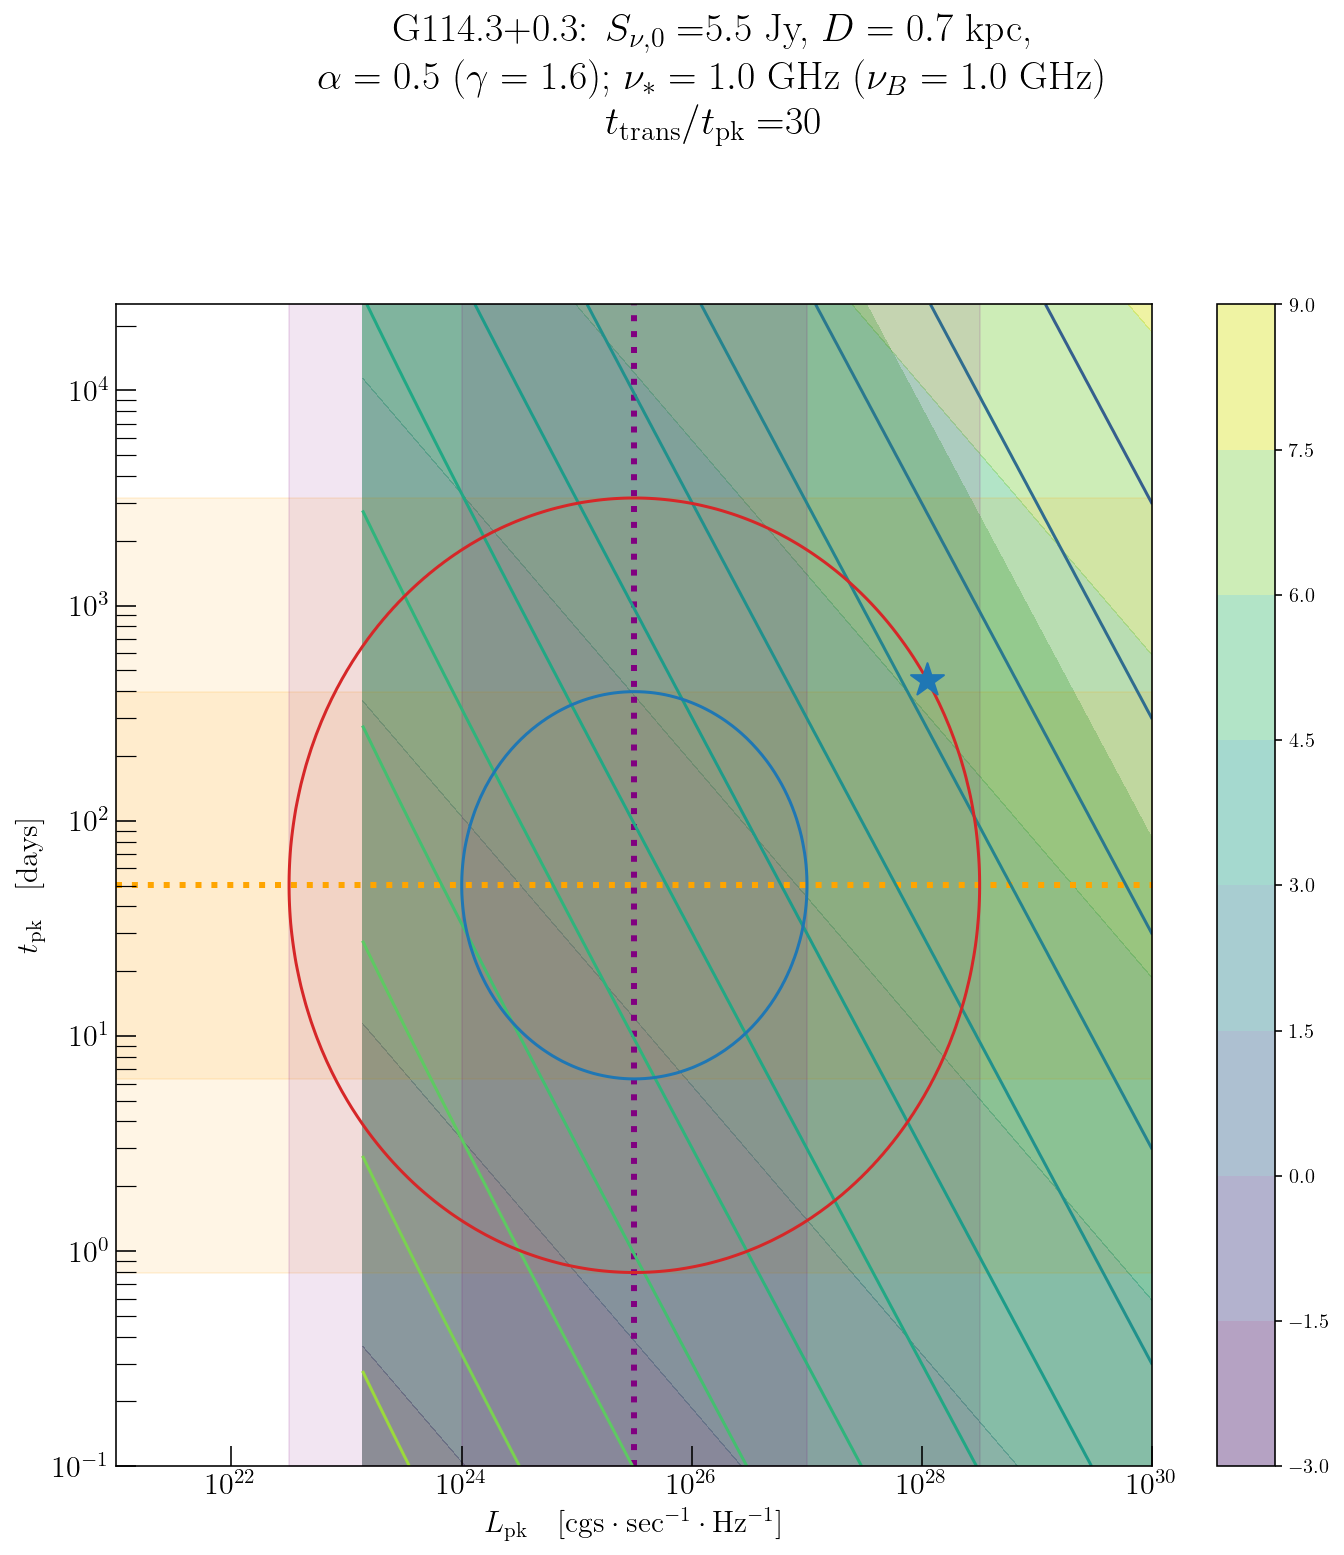

In [16]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

num_maskQ = False # numerically mask?
aberr_maskQ = False # mask aberration?

fig, ax = plt.subplots()

# axion properties
nu_pivot = 1. # [GHz]
nu_Bietenholz = 1. # [GHz] freq. of Bietenholz distribution
ma_ref = pt.ma_from_nu(nu_pivot)
ga_ref, ga_cast = 1.e-10, 6.e-11
ga_lvls = np.arange(-14., -3.5, 0.5) # axion photon coupling levels

# dark matter velocity dispersion:
deltaE_over_E = 1.e-3
delta_nu = nu_pivot*deltaE_over_E # [GHz]
# experiment:
exper_mode = ap.SKA_exper_nu(nu_pivot)
dish_area, window, Tr, _ = ap.SKA_specs(nu_pivot, exper_mode)

# S/N ratio:
sn_ratio_threshold = 2.

# SNR properties
aber_lim = 1.e-2 # limit to the aberration

t_trans_over_t_peak = 30. # t_trans/t_peak ratio
t_extra = 0. # [years] extra age to add
# name = 'G65.3+5.7' # great reach!
# name = 'G114.3+0.3' # best reach!
name = choice(list(snrs_cut.keys()))
snr = snrs_cut[name]

alpha = snr.alpha
gamma = ap.gamma_from_alpha(alpha)
S0 = snr.get_flux_density() # [Jy] spectral irrad. today
distance = snr.distance # [kpc]
area = 4.*pi*(distance*ct._kpc_over_cm_)**2. # [cm^2]
L0 = (S0*ct._Jy_over_cgs_irrad_)*area # [cgs]
size = snr.sr

# noise
l, b = snr.l, snr.b
Tbg408 = ap.bg_408_temp(l+180., -b,
                        size=size, average=True)
# Tnoise = ap.T_noise(nu_pivot, Tbg_at_408=Tbg408, Tr=Tr)

# SNR early-time evolution: from Bietenholz et al., Table 4.
# All:
muLt, sigLt = 1.7, 0.9 # mean, std.: log(t_peak/days)
muLL, sigLL = 25.5, 1.5 # mean, std.: log(L_peak/c.g.s.)

##########
# ARRAYS #
##########

# tpk and Lpk arrays
# Nsteps  = 75
Nsteps  = 201
tpk_arr = np.logspace(muLt-3.*sigLt, muLt+3.*sigLt, Nsteps+1) # [days]
Lpk_arr = np.logspace(muLL-3.*sigLL, muLL+3.*sigLL, Nsteps+2) # [cgs]

# peak luminosity and time grids
Lpk_Gr, tpk_Gr = np.meshgrid(Lpk_arr, tpk_arr, indexing='xy')
# going from Bietenholz peak Luminosities to pivot luminosities (at 1 GHz)
from_Bieten_to_pivot = (nu_pivot/nu_Bietenholz)**-alpha
Lpk_arr *= from_Bieten_to_pivot
Lpk_Gr *= from_Bieten_to_pivot

# transition time
tt_arr = t_trans_over_t_peak*(tpk_arr/365.) # [years]
tt_Gr = t_trans_over_t_peak*(tpk_Gr/365.) # [years]

# number of sigmas:
sigs_Gr = np.sqrt(((log10(Lpk_Gr)-muLL)/sigLL)**2 + ((log10(tpk_Gr)-muLt)/sigLt)**2)

# peak spectral irradiance and suppression:
sup_Gr = L0/Lpk_Gr

# computing t_age [years]
tage_Gr = ap.tage_compute(Lpk_Gr, tpk_Gr, tt_Gr, L0, gamma)

# fractional peak time:
ftpk_Gr = tpk_Gr/365./tage_Gr

# fractional transition time:
ftt_Gr = tt_Gr/tage_Gr
# ftt_Gr2 = ap.ftt(gamma, ftpk_Gr, sup_Gr)
# if not bool(((ftt_Gr2/ftt_Gr).min() + (ftt_Gr2/ftt_Gr).max())/2.):
#     raise ValueError("Two methods to compute t_trans do not match.")

# aberration:
solar_period = 2.4e8 # [years]
solar_mw_radius = ct._Sun_to_gal_center_ # [kpc]
ab_Gr = (2.*pi*tage_Gr/solar_period)*(solar_mw_radius/distance)

# masks:
peak_mask = (ftt_Gr/ftpk_Gr <= 1.) # t_trans > t_pk
trans_mask = (log10(ftt_Gr) >= 0.) # t_trans > t_age
sup_mask = (log10(sup_Gr) >= 0.) # supression > 1.

total_mask = peak_mask # starting mask: 't_trans > t_pk' mask
total_mask = np.logical_or(total_mask, trans_mask) # adding 't_trans > t_age' mask
total_mask = np.logical_or(total_mask, sup_mask) # adding 'suppression > 1' mask

if aberr_maskQ:
    ab_mask = (log10(ab_Gr/aber_lim) >= 0.) # aberration > limit
    total_mask = np.logical_or(total_mask, ab_mask) # adding 'aberration > limit' mask

numeric_mask = (np.logical_not(total_mask)).astype(float) # making those cases 0.

# S_echo grid at pivot frequency
Se_Gr = ec.echo_an_sup(ma_ref, ga_ref,
                       Lpk_Gr, distance, S0,
                       tage_Gr, gamma, tpk_Gr,
                       deltaE_over_E=deltaE_over_E)
# Se_Gr *= (nu_ref/nu_pivot)**-alpha

if num_maskQ:
    Se_Gr *= numeric_mask
    tage_Gr *= numeric_mask
else:
    Se_Gr = np.ma.masked_array(Se_Gr, mask=total_mask)
    tage_Gr = np.ma.masked_array(tage_Gr, mask=total_mask)

# signal-to-noise ratio grid
snratio_Gr = ec.snr_fn(Se_Gr, nu_pivot, delta_nu,
                       Tbg_408=Tbg408, fDelta=0.721, tobs=100.)
snratio_Gr = np.abs(snratio_Gr)

# ga grid
ga_Gr = ec.ga_reach(sn_ratio_threshold, snratio_Gr, ga_ref)
ga_Gr = np.nan_to_num(ga_Gr)

# contours for best possible ga
ax.contour(Lpk_arr, tpk_arr, log10(ga_Gr), levels=ga_lvls)
ax.contourf(Lpk_arr, tpk_arr, log10(ga_Gr), levels=[log10(ga_cast), 100.], colors=['g'], alpha=0.2, zorder=-1)

# contours for the corresponding age:
agecs = ax.contourf(Lpk_arr, tpk_arr, log10(tage_Gr), alpha=0.4, zorder=-10)
fig.colorbar(agecs)

# contours for the corresponding fractional transition time:
# fttcs = ax.contourf(Lpk_arr, tpk_arr, log10(ftt_best), alpha=0.4, zorder=-10)
# fig.colorbar(fttcs)

# Lpk
ax.fill_betweenx(tpk_arr, 10.**(muLL-sigLL), 10.**(muLL+sigLL), zorder=-1, color='purple', alpha=0.1)
ax.fill_betweenx(tpk_arr, 10.**(muLL-2*sigLL), 10.**(muLL+2*sigLL), zorder=-2, color='purple', alpha=0.1)
ax.axvline(10.**muLL, color='purple', ls=':', zorder=-1, lw=3.)

ax.fill_between(Lpk_arr, 10.**(muLt-sigLt), 10.**(muLt+sigLt), zorder=-3, color='orange', alpha=0.1)
ax.fill_between(Lpk_arr, 10.**(muLt-2*sigLt), 10.**(muLt+2*sigLt), zorder=-4, color='orange', alpha=0.1)
ax.axhline(10.**muLt, color='orange', ls=':', zorder=-1, lw=3.)

ax.contour(Lpk_arr, tpk_arr, sigs_Gr, levels=[1., 2.], colors=['C0', 'C3'], linestyles=['-', '-'])

# searching for the lowest ga within 2sigmas
outside_2sig = (sigs_Gr > 2.)
ga_within = np.ma.masked_array(ga_Gr, mask=outside_2sig)
idx_ga_lowest = ga_within.argmin()

ga_2sig_best = (ga_Gr.flatten())[idx_ga_lowest]
tpk_2sig_best = (tpk_Gr.flatten())[idx_ga_lowest]
Lpk_2sig_best = (Lpk_Gr.flatten())[idx_ga_lowest]
tage_2sig_best = (tage_Gr.flatten())[idx_ga_lowest]
ftt_2sig_best = (ftt_Gr.flatten())[idx_ga_lowest]

print(name,)
print('\n', '2-sig best ga:', ga_2sig_best)
print('2-sig best tpk:', tpk_2sig_best)
print('2-sig best Lpk:', Lpk_2sig_best)
print('2-sig best tage:', tage_2sig_best)
print('2-sig best ttrans:', tage_2sig_best*ftt_2sig_best)
print('2-sig best ftt:', ftt_2sig_best, '\n')

ax.scatter(Lpk_2sig_best, tpk_2sig_best, s=300., zorder=10., marker='*')

title = name+r": $S_{\nu, 0}=$"+r"${{{}}}$ Jy, ".format(S0)+r"$D={{{:.1f}}}$ kpc, ".format(distance)+"\n"+r"$\alpha = {{{}}}$ ".format(alpha)+"($\gamma = {{{}}}$); ".format(ap.gamma_from_alpha(alpha))+r"$\nu_* = {{{:.2}}}$ GHz".format(nu_pivot)+r" ($\nu_B = {{{:.2}}}$ GHz)".format(nu_Bietenholz)+"\n"+r"$t_{\rm trans}/t_{\rm pk} = $"+r"${{{}}}$".format(int(t_trans_over_t_peak));

file_name = current_dir+"/plots/param_space/analytic/{}_alpha-{}_S0-{:.1f}_D-{:.1f}_ttrat-{}_nu-{:.1e}_nuB={:.1e}.pdf".format(name, alpha, S0, distance, int(t_trans_over_t_peak), nu_pivot, nu_Bietenholz).replace(" ", "")
print(file_name)

ax.set_ylabel(r"$t_{\rm pk}\quad[\mathrm{days}]$", fontsize=label_sz);
ax.set_xlabel(r"$L_{\rm pk}\quad[\mathrm{cgs \cdot sec^{-1} \cdot Hz^{-1}}]$", fontsize=label_sz);
ax.set_xscale("log");ax.set_yscale("log");
ax.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.)

# contourf(Lpk_arr, tpk_arr, log10(ftt_Gr), levels=[0., 100.], colors=['b'], alpha=0.2, zorder=-1)

fig.suptitle(title, fontsize=title_sz, y=1.075);
fig.tight_layout();
# plt.savefig(file_name, bbox_inches="tight")

In [17]:
(0.020749133546569924)**(1.76-1.)

0.052592034799284496

In [18]:
(0.004838396890047596)**(1.424-1.)

0.10430699451757248

#### Finding most optimistic $g_{a\gamma\gamma}$ reach

Computing optimistic parameters:

In [38]:
# axion properties
nu_pivot = 1. # [GHz]
# nu_Bietenholz = 1.
nuBs = [1., 4., 8., 10.] # [GHz] freq. of Bietenholz distribution
ma_ref = pt.ma_from_nu(nu_pivot)
ga_ref = 1.e-10

# dark matter velocity dispersion:
deltaE_over_E = 1.e-3
delta_nu = nu_pivot*deltaE_over_E # [GHz]
# experiment:
exper_mode = ap.SKA_exper_nu(nu_pivot)
dish_area, window, Tr, _ = ap.SKA_specs(nu_pivot, exper_mode)

# S/N ratio:
sn_ratio_threshold = 2.

# SNR properties
# t_trans_over_t_peak = 30.
ttrs = [10., 30., 50., 100.] # t_trans/t_peak ratio
t_extra = 0. # [years] extra age to add

# SNR early-time evolution: from Bietenholz et al., Table 4.
# All:
muLt, sigLt = 1.7, 0.9 # mean, std.: log(t_peak/days)
muLL, sigLL = 25.5, 1.5 # mean, std.: log(L_peak/c.g.s.)

# analytically computing dictionary:

sig2_dict = {}

for name, snr in tqdm(snrs_cut.items()):
    for nu_Bietenholz in nuBs:
        for t_trans_over_t_peak in ttrs:
            
            # tpk and Lpk arrays
            Nsteps  = 201
            tpk_arr = np.logspace(muLt-3.*sigLt, muLt+3.*sigLt, Nsteps+1) # [days]
            Lpk_arr = np.logspace(muLL-3.*sigLL, muLL+3.*sigLL, Nsteps+2) # [cgs]
            
            # peak luminosity and time grids
            Lpk_Gr, tpk_Gr = np.meshgrid(Lpk_arr, tpk_arr, indexing='xy')
            
            # transition time
            tt_arr = t_trans_over_t_peak*(tpk_arr/365.) # [years]
            tt_Gr = t_trans_over_t_peak*(tpk_Gr/365.) # [years]
            
            # number of sigmas:
            sigs_Gr = np.sqrt(((log10(Lpk_Gr)-muLL)/sigLL)**2 + ((log10(tpk_Gr)-muLt)/sigLt)**2)
            
            alpha = snr.alpha
            gamma = ap.gamma_from_alpha(alpha)
            S0 = snr.get_flux_density() # [Jy] spectral irrad. today
            distance = snr.distance # [kpc]
            area = 4.*pi*(distance*ct._kpc_over_cm_)**2. # [cm^2]
            L0 = (S0*ct._Jy_over_cgs_irrad_)*area # [cgs]
            size = snr.sr
            
            # going from Bietenholz peak Luminosities to pivot luminosities (at 1 GHz)
            from_Bieten_to_pivot = (nu_pivot/nu_Bietenholz)**-alpha
            Lpk_arr *= from_Bieten_to_pivot
            Lpk_Gr *= from_Bieten_to_pivot
            
            # noise
            l, b = snr.l, snr.b
            Tbg408 = ap.bg_408_temp(l+180., -b,
                                    size=size, average=True)
            
            # peak spectral irradiance and suppression:
            sup_Gr = L0/Lpk_Gr
            
            # computing t_age [years]
            tage_Gr = ap.tage_compute(Lpk_Gr, tpk_Gr, tt_Gr, L0, gamma)
            
            # fractional peak time:
            ftpk_Gr = tpk_Gr/365./tage_Gr
            
            # fractional transition time:
            ftt_Gr = tt_Gr/tage_Gr
            
            # masks:
            peak_mask = (ftt_Gr/ftpk_Gr <= 1.) # t_trans > t_pk
            trans_mask = (log10(ftt_Gr) >= 0.) # t_trans > t_age
            sup_mask = (log10(sup_Gr) >= 0.) # supression > 1.
            
            total_mask = peak_mask # starting mask: 't_trans > t_pk' mask
            total_mask = np.logical_or(total_mask, trans_mask) # adding 't_trans > t_age' mask
            total_mask = np.logical_or(total_mask, sup_mask) # adding 'suppression > 1' mask
            
            # S_echo grid at pivot frequency
            Se_Gr = ec.echo_an_sup(ma_ref, ga_ref,
                                   Lpk_Gr, distance, S0,
                                   tage_Gr, gamma, tpk_Gr,
                                   deltaE_over_E=deltaE_over_E)
            
            Se_Gr = np.ma.masked_array(Se_Gr, mask=total_mask)
            tage_Gr = np.ma.masked_array(tage_Gr, mask=total_mask)
            
            # signal-to-noise ratio grid
            snratio_Gr = ec.snr_fn(Se_Gr, nu_pivot, delta_nu,
                                   Tbg_408=Tbg408, fDelta=0.721, tobs=100.)
            snratio_Gr = np.abs(snratio_Gr)
            
            # ga grid
            ga_Gr = ec.ga_reach(sn_ratio_threshold, snratio_Gr, ga_ref)
            ga_Gr = np.nan_to_num(ga_Gr)
            
            # searching for the lowest ga within 2sigmas
            outside_2sig = (sigs_Gr > 2.)
            ga_within = np.ma.masked_array(ga_Gr, mask=outside_2sig)
            idx_ga_lowest = ga_within.argmin()
            
            ga_2sig_best = (ga_Gr.flatten())[idx_ga_lowest]
            tpk_2sig_best = (tpk_Gr.flatten())[idx_ga_lowest]
            Lpk_2sig_best = (Lpk_Gr.flatten())[idx_ga_lowest]
            tage_2sig_best = (tage_Gr.flatten())[idx_ga_lowest]
            ftt_2sig_best = (ftt_Gr.flatten())[idx_ga_lowest]
            
            sig2_dict[name, nu_Bietenholz, t_trans_over_t_peak] = {'ga':ga_2sig_best,
                                                                   'tpk':tpk_2sig_best,
                                                                   'Lpk':Lpk_2sig_best,
                                                                   'tage':tage_2sig_best,
                                                                   'ftt':ftt_2sig_best}

 49%|████▉     | 30/61 [00:08<00:08,  3.55it/s]/home/chen/Code/axion_laser/github/workspace_notebooks/../astro.py:675: RuntimeWarning: overflow encountered in power
  """
/home/chen/Code/axion_laser/github/workspace_notebooks/../astro.py:675: RuntimeWarning: invalid value encountered in multiply
  """
/home/chen/Code/axion_laser/github/workspace_notebooks/../astro.py:680: RuntimeWarning: divide by zero encountered in true_divide
  frac_tpk : ratio of peak day to SNR age
/home/chen/Code/axion_laser/github/workspace_notebooks/../astro.py:680: RuntimeWarning: invalid value encountered in true_divide
  frac_tpk : ratio of peak day to SNR age
/home/chen/Code/axion_laser/github/workspace_notebooks/../echo.py:829: RuntimeWarning: invalid value encountered in multiply
  frac_tt_mask = 1.*np.heaviside(frac_tt-1., 1.) + frac_tt*np.heaviside(
100%|██████████| 61/61 [00:17<00:00,  3.52it/s]


Defining resulting $f_{tt}$ dictionary:

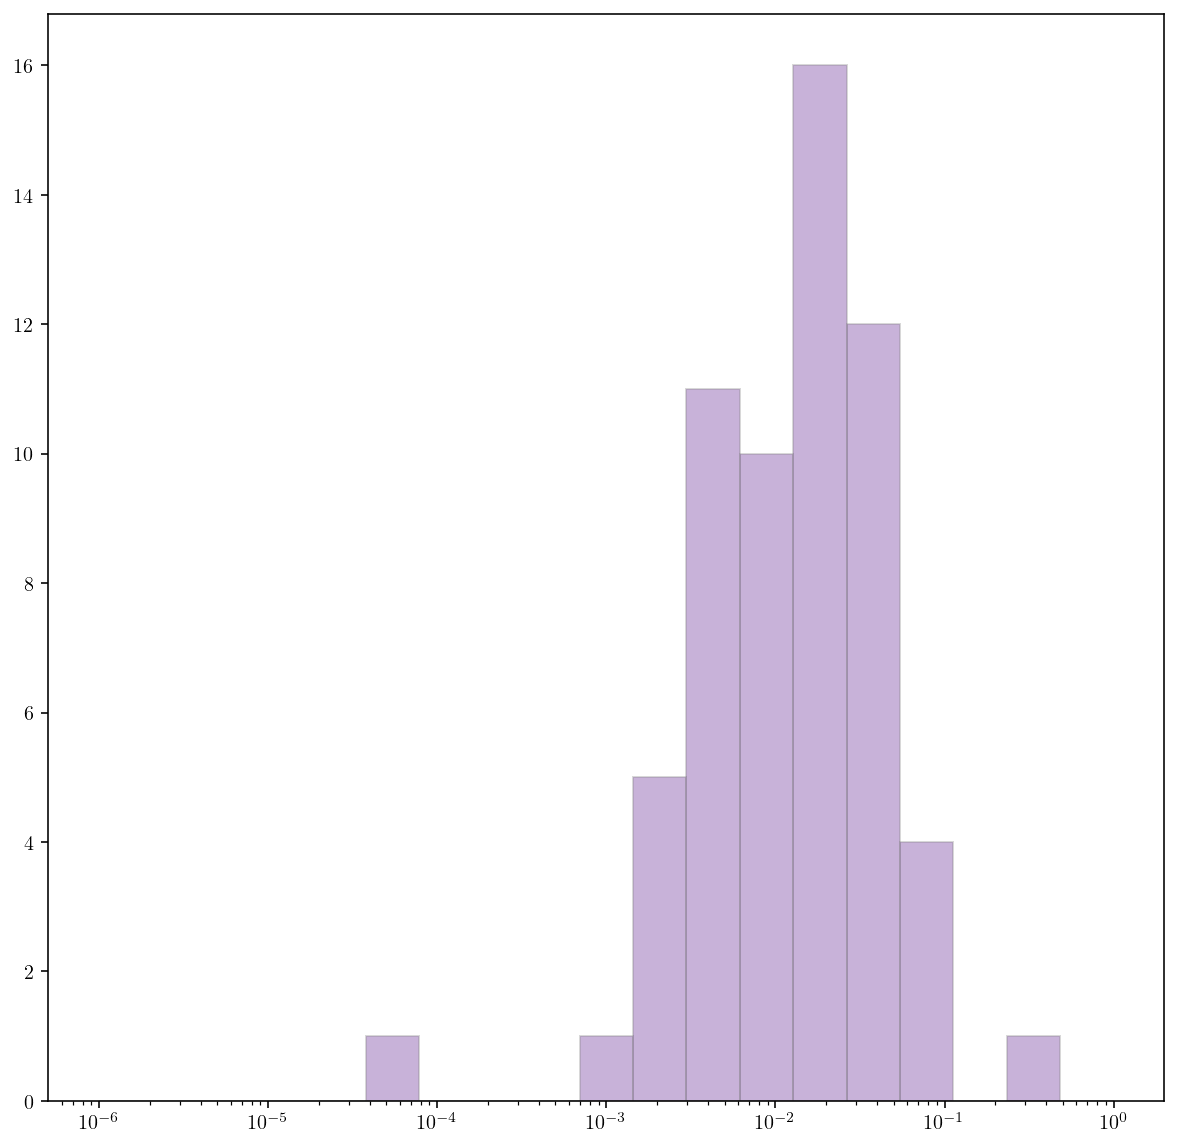

In [21]:
nuB = 1.
rat = 30.

fa_arr = np.array([val['ftt'] for key, val in sig2_dict.items() if key[1]==nuB and key[-1]==rat])

plt.hist(fa_arr,
         bins=np.logspace(-6,0,20),
         alpha=0.3,
         color='indigo',
         ec='grey',
         label=r"$\frac{t_{\rm trans}}{t_{\rm age}}$"
        )
plt.xscale("log");

In [22]:
fa_arr.min(), fa_arr.max(), fa_arr.mean(), np.median(fa_arr), fa_arr.std()

(6.126453740940703e-05,
 0.3305252763682037,
 0.025313639255224424,
 0.013749960972775548,
 0.043982938202269735)

Defining resulting $g_{a\gamma\gamma}$ dictionary:

In [23]:
ga_reach_dict = {key:val['ga'] for key, val in sig2_dict.items()}
key = min(ga_reach_dict, key=ga_reach_dict.get)
print(key, sig2_dict[key])

('G65.3+5.7', 10.0, 100.0) {'ga': 1.245102037465709e-10, 'tpk': 450.53791333602817, 'Lpk': 4.361179483994333e+28, 'tage': 17280.892559880635, 'ftt': 0.007142862807686444}


#### $g_{a\gamma\gamma}$ optimistic reach histograms

For different $\nu_{\rm Bietenholz}$:

/home/chen/Code/axion_laser/github/workspace_notebooks/plots/reach/analytic/GC_ga-reach_dist_ttrat-100.pdf


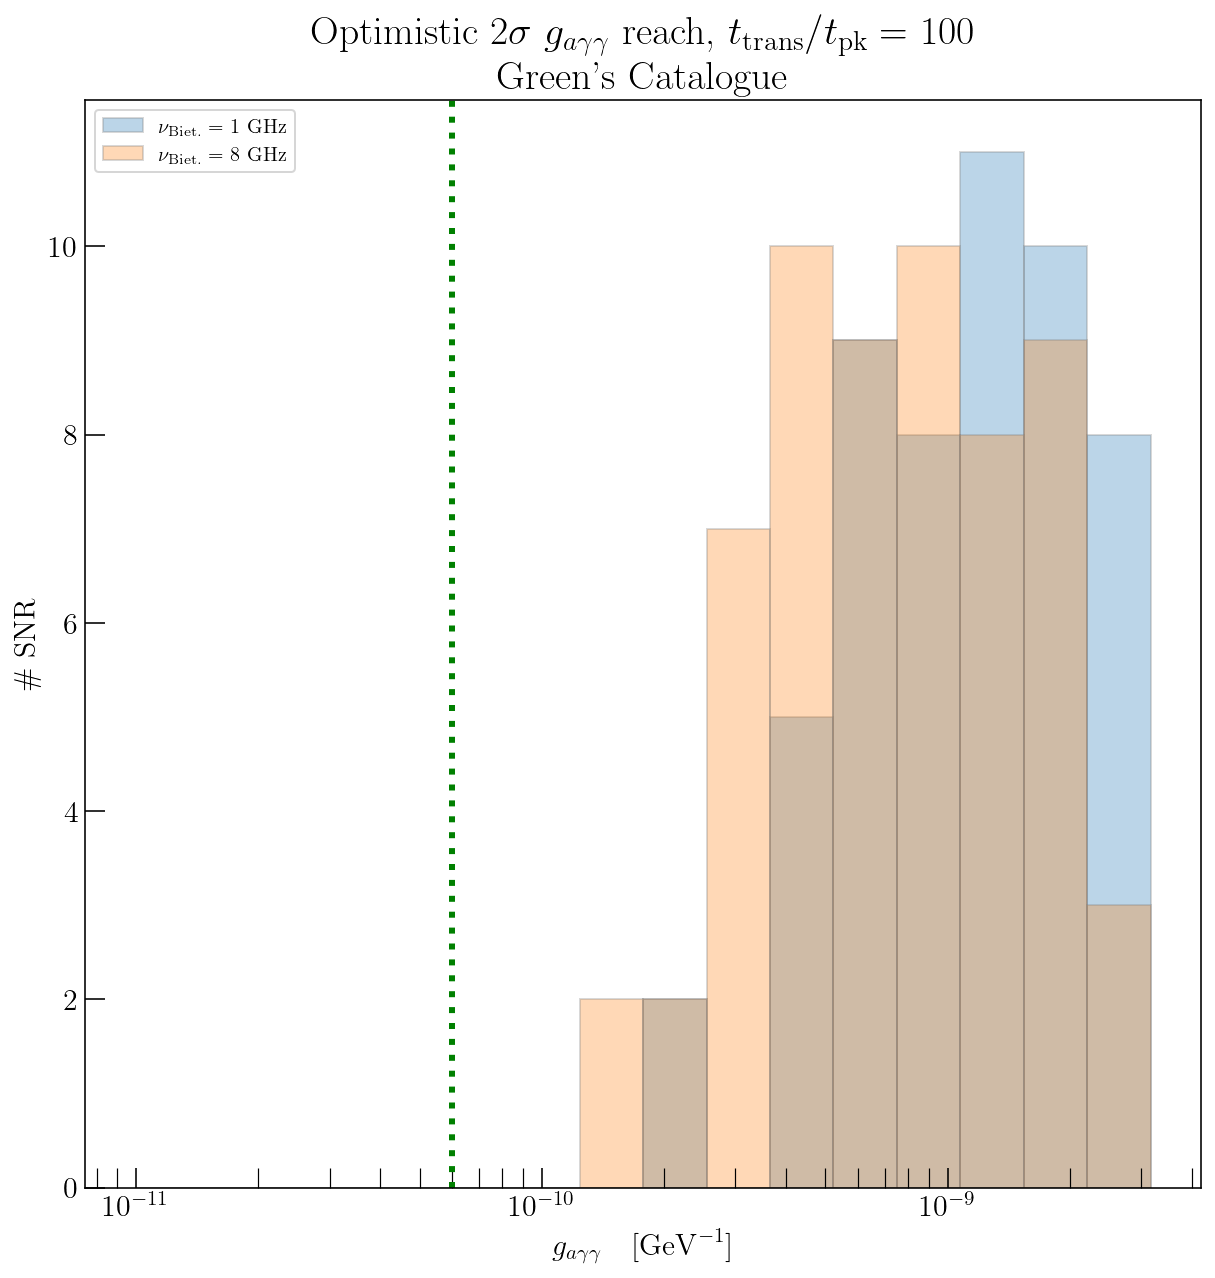

In [25]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

ga_cast = 6.e-11
bins = np.logspace(-11, -8.5, 17)

t_trans_over_t_peak = 100.

# for i, nuB in enumerate(nuBs):
for i, nuB in enumerate([1., 8.]):
    
    ga_reach_arr = [val for key, val in ga_reach_dict.items()
                    if key[1]==nuB and key[2]==t_trans_over_t_peak]
    
    ga_reach_arr = np.array(ga_reach_arr)
    
    plt.hist(ga_reach_arr,
             bins=bins,
             alpha=0.3,
             color='C'+str(i),
             ec='grey',
             label=r"$\nu_{\rm Biet.}=$ "+r"${{{}}}$ GHz".format(int(nuB))
            )

plt.xscale("log");
plt.axvline(ga_cast, color='g', ls=':', lw=3.);

title = r"Optimistic $2\sigma$ $g_{a\gamma\gamma}$ reach, $t_{\rm trans}/t_{\rm pk} = $"+r" ${{{}}}$".format(int(t_trans_over_t_peak))+"\n"+"Green's Catalogue";

plt.title(title, fontsize=title_sz);
plt.ylabel(r"\# SNR", fontsize=label_sz);
plt.xlabel(r"$g_{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$", fontsize=label_sz);
plt.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.);
plt.legend(loc='best');

file_name = current_dir+"/plots/reach/analytic/GC_ga-reach_dist_ttrat-{}.pdf".format(int(t_trans_over_t_peak)).replace(" ", "")
print(file_name)

# plt.savefig(file_name, bbox_inches="tight")

For different $t_{\rm trans}/t_{\rm peak}$:

/home/chen/Code/axion_laser/github/workspace_notebooks/plots/reach/analytic/GC_ga-reach_dist_nuB-1.pdf


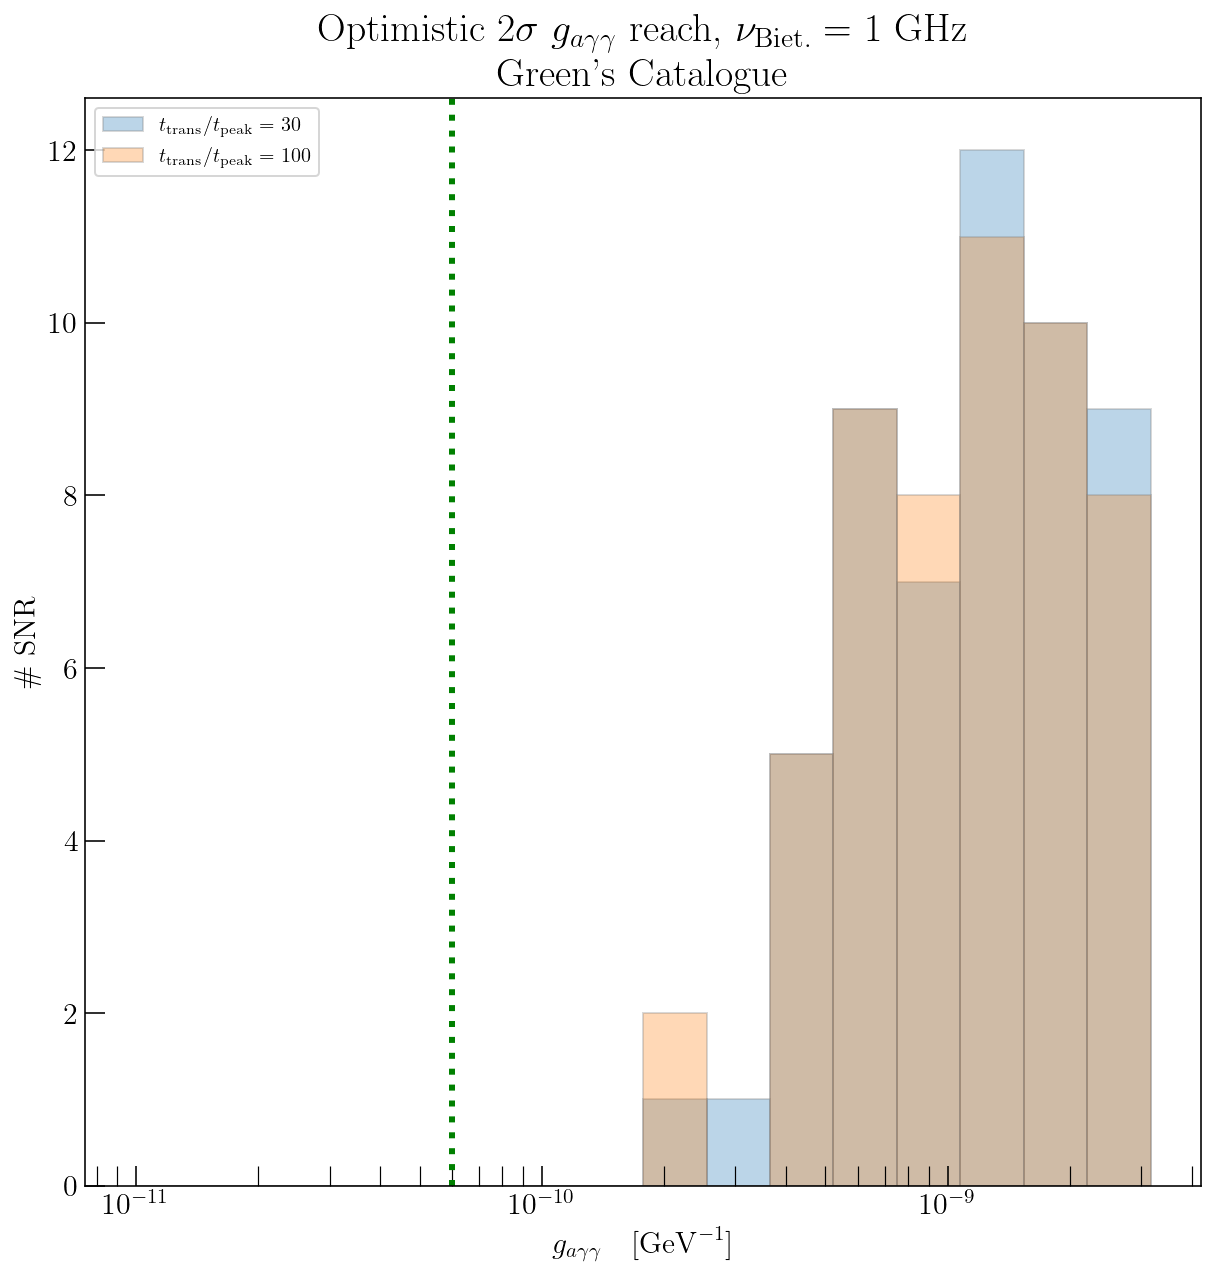

In [26]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

ga_cast = 6.e-11
bins = np.logspace(-11, -8.5, 17)
nuB = 1.

for i, t_trans_over_t_peak in enumerate([30., 100.]):
    
    ga_reach_arr = [val for key, val in ga_reach_dict.items()
                    if key[1]==nuB and key[2]==t_trans_over_t_peak]
    
    ga_reach_arr = np.array(ga_reach_arr)
    
    plt.hist(ga_reach_arr,
             bins=bins,
             alpha=0.3,
             color='C'+str(i),
             ec='grey',
             label=r"$t_{\rm trans}/t_{\rm peak}=$ "+r"${{{}}}$".format(int(t_trans_over_t_peak))
            )

plt.xscale("log");
plt.axvline(ga_cast, color='g', ls=':', lw=3.);

title = r"Optimistic $2\sigma$ $g_{a\gamma\gamma}$ reach, $\nu_{\rm Biet.} = $"+r" ${{{}}}$ GHz".format(int(nuB))+"\n"+"Green's Catalogue";

plt.title(title, fontsize=title_sz);
plt.ylabel(r"\# SNR", fontsize=label_sz);
plt.xlabel(r"$g_{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$", fontsize=label_sz);
plt.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.);
plt.legend(loc='best');

file_name = current_dir+"/plots/reach/analytic/GC_ga-reach_dist_nuB-{}.pdf".format(int(nuB)).replace(" ", "")
print(file_name)

# plt.savefig(file_name, bbox_inches="tight")

### 2.3 $(L_{\rm peak}, t_{\rm peak})$ parameter space: **Numeric**

N.B.: From CCV results, obtained assuming:

i. $g_{a\gamma\gamma} = 10^{-10}~\mathrm{GeV}^{-1}$

ii. $\nu_{\rm Bietenholz} = \nu_{\rm pivot} = 1~\mathrm{GHz}$

In [27]:
from scipy.interpolate import RectBivariateSpline as RBS
from scipy.interpolate import interp2d

# TODO: edit accordingly to read everything from the correct path.
# green path
green_path = "/home/buenabad/Documents/Physics/Projects/P11 - 2021 - snr_ghosts/green_snr/"

# loading pre-computed arrays
pre_Lpk_arr = np.loadtxt(green_path+"Lpk_arr.txt", delimiter=",")
pre_tpk_arr = np.loadtxt(green_path+"tpk_arr.txt", delimiter=",")

# peak luminosity and time grids
pre_Lpk_Gr, pre_tpk_Gr = np.meshgrid(pre_Lpk_arr, pre_tpk_arr, indexing='xy')

# sigmas contours on pre-computed grids
sigs_Gr = np.sqrt(((log10(pre_Lpk_Gr)-ct._mu_log10_Lpk_)/ct._sig_log10_Lpk_)**2 + ((log10(pre_tpk_Gr)-ct._mu_log10_tpk_)/ct._sig_log10_tpk_)**2)


def load_green_results(name, tt=(None, None), nuB=1.):
    """
    Function that loads the CCV numerical results for the SNRs from Green's Catalog.
    
    TODO: edit accordingly to read them from the correct path.
    """
    
    if not name in snrs_cut.keys():
        raise ValueError("name={} not available in results.".format(name))
    
    if type(tt) != tuple:
        raise ValueError("Argument 'tt', of how to deal with the transition time 't_trans' must be a 2-tuple, of the form ('method', #), 'method' being either 'fixed'/'ratio'.")
    
    if not tt[0] in ["fixed", "ratio"]:
        raise ValueError("tt[0] can only be 'fixed' or 'ratio'")
    
    if nuB == 1.:
        nuB_str = ""
    else:
        nuB_str = "_nuB-{}".format(nuB)
    
    folder = green_path+name+"/"
    file = "{}_Lpk-tpk_{}-{}{}.txt".format(name, tt[0], int(tt[1]), nuB_str)
    
    sn = np.loadtxt(folder+"sn_"+file, delimiter=",")
    echo = np.loadtxt(folder+"echo_"+file, delimiter=",")
    tage = np.loadtxt(folder+"tage_"+file, delimiter=",")
    
    return sn, echo, tage

OSError: /home/buenabad/Documents/Physics/Projects/P11 - 2021 - snr_ghosts/green_snr/Lpk_arr.txt not found.

NameError: name 'load_green_results' is not defined

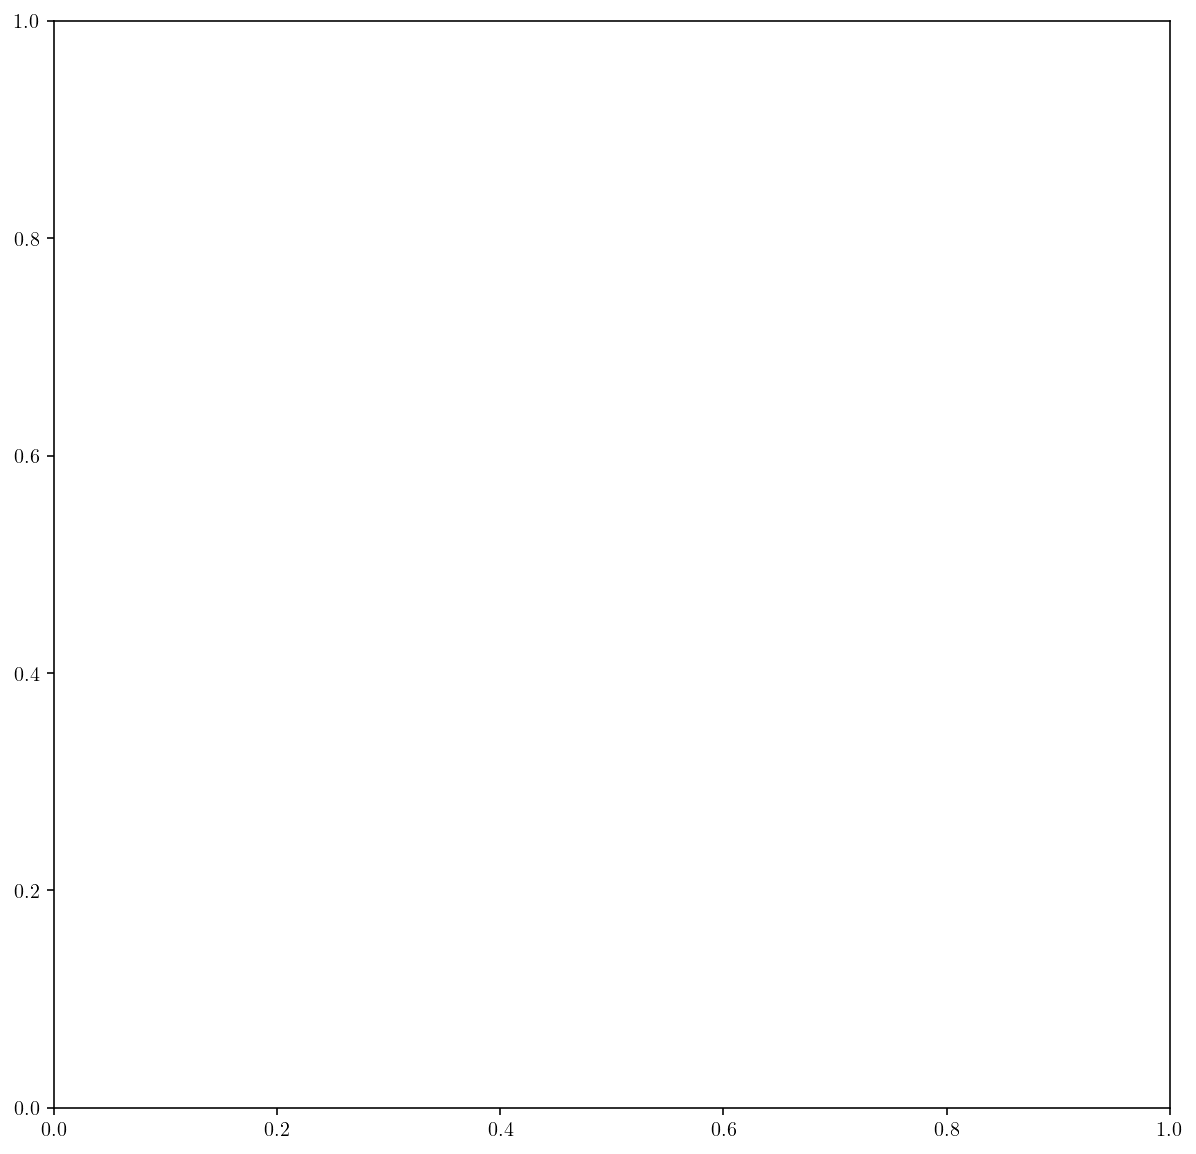

In [30]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

fig, ax = plt.subplots()

# energetics;
nu_pivot = 1. # [GHz]
nu_Bietenholz = 1. # [GHz] freq. of Bietenholz distribution

# axion parameters
ma_ref = pt.ma_from_nu(nu_pivot)
ga_ref = 1.e-10
ga_lvls = np.arange(-14., -3.5, 0.5) # axion photon coupling levels

# SNR time properties
t_extra = 0. # [years] extra age to add
tt_ratio = 30. # t_trans/t_peak ratio

# S/N ratio:
sn_ratio_threshold = 2.

# SNR:
name = 'G114.3+0.3'
snr = snrs_cut[name]

# SNR properties:
alpha = snr.alpha
gamma = ap.gamma_from_alpha(alpha)
S0 = snr.get_flux_density() # [Jy] spectral irrad. today
distance = snr.distance # [kpc]
area = 4.*pi*(distance*ct._kpc_over_cm_)**2. # [cm^2]
L0 = (S0*ct._Jy_over_cgs_irrad_)*area # [cgs]
size = snr.sr

# SNR results
sn_Gr, echo_Gr, tage_Gr = load_green_results(name, tt=("ratio", tt_ratio), nuB=nu_Bietenholz)

# going from Bietenholz peak Luminosities to pivot luminosities (at 1 GHz)
from_Bieten_to_pivot = (nu_pivot/nu_Bietenholz)**-alpha

Lpk_arr, tpk_arr = np.copy(pre_Lpk_arr), np.copy(pre_tpk_arr)
Lpk_Gr, tpk_Gr = np.copy(pre_Lpk_Gr), np.copy(pre_tpk_Gr)

Lpk_arr *= from_Bieten_to_pivot
Lpk_Gr *= from_Bieten_to_pivot

sup_Gr = L0/Lpk_Gr
tt_Gr = tt_ratio*(tpk_Gr/365.) # [years]
ftt_Gr = tt_Gr/tage_Gr

# masks:
peak_mask = (tt_Gr/(tpk_Gr/365.) <= 1.) # t_trans > t_pk
trans_mask = (log10(ftt_Gr) >= 0.) # t_trans > t_age
sup_mask = (log10(sup_Gr) >= 0.) # supression > 1.

total_mask = peak_mask # starting mask: 't_trans > t_pk' mask
total_mask = np.logical_or(total_mask, trans_mask) # adding 't_trans > t_age' mask
total_mask = np.logical_or(total_mask, sup_mask) # adding 'suppression > 1' mask

tage_Gr = np.ma.masked_array(tage_Gr, mask=total_mask)

sn_Gr = np.ma.masked_array(sn_Gr, mask=total_mask)
ga_Gr = ec.ga_reach(sn_ratio_threshold, sn_Gr, ga_ref)
ga_Gr = np.nan_to_num(ga_Gr)

# searching for the lowest ga within 2sigmas
outside_2sig = (sigs_Gr > 2.)
ga_within = np.ma.masked_array(ga_Gr, mask=outside_2sig)
idx_ga_lowest = ga_within.argmin()

ga_2sig_best = (ga_Gr.flatten())[idx_ga_lowest]
tpk_2sig_best = (tpk_Gr.flatten())[idx_ga_lowest]
Lpk_2sig_best = (Lpk_Gr.flatten())[idx_ga_lowest]
tage_2sig_best = (tage_Gr.flatten())[idx_ga_lowest]
ftt_2sig_best = (ftt_Gr.flatten())[idx_ga_lowest]

print(name,)
print('\n', '2-sig best ga:', ga_2sig_best)
print('2-sig best tpk:', tpk_2sig_best)
print('2-sig best Lpk:', Lpk_2sig_best)
print('2-sig best tage:', tage_2sig_best)
print('2-sig best ttrans:', tage_2sig_best*ftt_2sig_best)
print('2-sig best ftt:', ftt_2sig_best, '\n')

# plt.contourf(pre_Lpk_arr, pre_tpk_arr, log10(sn_result))

# contours for best possible ga
ax.contour(Lpk_arr, tpk_arr, log10(ga_Gr), levels=ga_lvls)
ax.contourf(Lpk_arr, tpk_arr, log10(ga_Gr), levels=[log10(ga_cast), 100.], colors=['indigo'], alpha=0.2, zorder=-1)

# contours for the corresponding age:
agecs = ax.contourf(Lpk_arr, tpk_arr, log10(tage_Gr), alpha=0.4, zorder=-10)
fig.colorbar(agecs)

ax.contour(Lpk_arr, tpk_arr, sigs_Gr, levels=[1., 2.], colors=['C0', 'C3'], linestyles=['-', '-'])
ax.scatter(Lpk_2sig_best, tpk_2sig_best, s=300., zorder=10., marker='*')

file_name = current_dir+"/plots/param_space/numeric/{}_alpha-{}_S0-{:.1f}_D-{:.1f}_ttrat-{}_nu-{:.1e}_nuB={:.1e}.pdf".format(name, alpha, S0, distance, int(tt_ratio), nu_pivot, nu_Bietenholz).replace(" ", "")
print(file_name)

title = name+r": $S_{\nu, 0}=$"+r"${{{}}}$ Jy, ".format(S0)+r"$D={{{:.1f}}}$ kpc, ".format(distance)+"\n"+r"$\alpha = {{{}}}$ ".format(alpha)+"($\gamma = {{{}}}$); ".format(ap.gamma_from_alpha(alpha))+r"$\nu_* = {{{:.2}}}$ GHz".format(nu_pivot)+r" ($\nu_B = {{{:.2}}}$ GHz)".format(nu_Bietenholz)+"\n"+r"$t_{\rm trans}/t_{\rm pk} = $"+r"${{{}}}$".format(int(tt_ratio));

plt.xscale("log"),plt.yscale("log");
ax.set_ylabel(r"$t_{\rm pk}\quad[\mathrm{days}]$", fontsize=label_sz);
ax.set_xlabel(r"$L_{\rm pk}\quad[\mathrm{cgs \cdot sec^{-1} \cdot Hz^{-1}}]$", fontsize=label_sz);
ax.set_xscale("log");ax.set_yscale("log");
ax.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.)

fig.suptitle(title, fontsize=title_sz, y=1.075);
fig.tight_layout();
# plt.savefig(file_name, bbox_inches="tight")

In [32]:
# energetics
nu_pivot = 1. # [GHz]
nu_Bietenholz = 1. # [GHz] freq. of Bietenholz distribution

# axion parameters
ma_ref = pt.ma_from_nu(nu_pivot)
ga_ref = 1.e-10
ga_lvls = np.arange(-14., -3.5, 0.5) # axion photon coupling levels

# SNR time properties
t_extra = 0. # [years] extra age to add
tt_ratio = 30. # t_trans/t_peak ratio

# S/N ratio:
sn_ratio_threshold = 2.

sig2_dict_num = {}
for name, snr in tqdm(snrs_cut.items()):
    
    # SNR properties:
    alpha = snr.alpha
    gamma = ap.gamma_from_alpha(alpha)
    S0 = snr.get_flux_density() # [Jy] spectral irrad. today
    distance = snr.distance # [kpc]
    area = 4.*pi*(distance*ct._kpc_over_cm_)**2. # [cm^2]
    L0 = (S0*ct._Jy_over_cgs_irrad_)*area # [cgs]
    size = snr.sr
    
    # SNR results
    sn_Gr, echo_Gr, tage_Gr = load_green_results(name, tt=("ratio", tt_ratio), nuB=nu_Bietenholz)
    
    # going from Bietenholz peak Luminosities to pivot luminosities (at 1 GHz)
    from_Bieten_to_pivot = (nu_pivot/nu_Bietenholz)**-alpha
    
    Lpk_arr, tpk_arr = np.copy(pre_Lpk_arr), np.copy(pre_tpk_arr)
    Lpk_Gr, tpk_Gr = np.copy(pre_Lpk_Gr), np.copy(pre_tpk_Gr)

    Lpk_arr *= from_Bieten_to_pivot
    Lpk_Gr *= from_Bieten_to_pivot
    
    sup_Gr = L0/Lpk_Gr
    tt_Gr = tt_ratio*(tpk_Gr/365.) # [years]
    ftt_Gr = tt_Gr/tage_Gr
    
    # masks:
    peak_mask = (tt_Gr/(tpk_Gr/365.) <= 1.) # t_trans > t_pk
    trans_mask = (log10(ftt_Gr) >= 0.) # t_trans > t_age
    sup_mask = (log10(sup_Gr) >= 0.) # supression > 1.
    
    total_mask = peak_mask # starting mask: 't_trans > t_pk' mask
    total_mask = np.logical_or(total_mask, trans_mask) # adding 't_trans > t_age' mask
    total_mask = np.logical_or(total_mask, sup_mask) # adding 'suppression > 1' mask
    
    tage_Gr = np.ma.masked_array(tage_Gr, mask=total_mask)
    
    sn_Gr = np.ma.masked_array(sn_Gr, mask=total_mask)
    ga_Gr = ec.ga_reach(sn_ratio_threshold, sn_Gr, ga_ref)
    ga_Gr = np.nan_to_num(ga_Gr)
    
    # searching for the lowest ga within 2sigmas
    outside_2sig = (sigs_Gr > 2.)
    ga_within = np.ma.masked_array(ga_Gr, mask=outside_2sig)
    idx_ga_lowest = ga_within.argmin()
    
    ga_2sig_best = (ga_Gr.flatten())[idx_ga_lowest]
    tpk_2sig_best = (tpk_Gr.flatten())[idx_ga_lowest]
    Lpk_2sig_best = (Lpk_Gr.flatten())[idx_ga_lowest]
    tage_2sig_best = (tage_Gr.flatten())[idx_ga_lowest]
    ftt_2sig_best = (ftt_Gr.flatten())[idx_ga_lowest]
    
    sig2_dict_num[name] = {'ga':ga_2sig_best,
                           'tpk':tpk_2sig_best,
                           'Lpk':Lpk_2sig_best,
                           'tage':tage_2sig_best,
                           'ftt':ftt_2sig_best}

  0%|          | 0/61 [00:00<?, ?it/s]


NameError: name 'load_green_results' is not defined

In [33]:
num_ga_reach_dict = {name:val['ga'] for name, val in sig2_dict_num.items()}
min_name = min(num_ga_reach_dict, key=num_ga_reach_dict.get)
print min_name, sig2_dict_num[min_name]

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(min_name, sig2_dict_num[min_name])? (<ipython-input-33-b5407c2c5723>, line 3)

In [34]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

ga_cast = 6.e-11
nu_Bietenholz = 1.
t_trans_over_t_peak = 30.

tmp_ga_reach = [val for key, val in ga_reach_dict.items() if (key[1]==1.) and (key[-1]==30.)]
ga_reach_arr = np.array(tmp_ga_reach)
num_ga_reach_arr = np.array(num_ga_reach_dict.values())

bins = np.logspace(-11, -8.5, 15)

plt.hist(ga_reach_arr,
         bins=bins,
         alpha=0.5,
         color='dodgerblue',
         ec='grey',
         label="Analytic"
        )

plt.hist(num_ga_reach_arr,
         bins=bins,
         alpha=0.5,
         color='tomato',
         ec='grey',
         label="Numeric"
        )

plt.xscale("log");
plt.axvline(ga_cast, color='g', ls=':', lw=3.);

title = r"Optimistic $2\sigma$ $g_{a\gamma\gamma}$ reach:"+"\n"+r"$\nu_B = {{{:.2}}}$ GHz, ".format(nu_Bietenholz)+r"$t_{\rm trans}/t_{\rm pk} = $"+r"${{{}}}$".format(int(t_trans_over_t_peak))+"\n"+"Green's Catalogue";

plt.title(title, fontsize=title_sz);
plt.ylabel(r"\# SNR", fontsize=label_sz);
plt.xlabel(r"$g_{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$", fontsize=label_sz);
plt.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.);

file_name = current_dir+"/plots/reach/GC_ga-reach_dist_ttrat-{}_nuB={:.1e}.pdf".format(int(t_trans_over_t_peak), nu_Bietenholz).replace(" ", "")
print file_name
plt.legend(loc="best");

# plt.savefig(file_name, bbox_inches="tight")

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(file_name)? (<ipython-input-34-295c1a7cebab>, line 44)

In [ ]:
snrs_cut[min_name].__dict__

In [ ]:
sig2_dict_num[min_name]

### 2.4 $(m_a, g_{a\gamma\gamma})$ parameter space

In [36]:
min_name = min(num_ga_reach_dict, key=num_ga_reach_dict.get)
# min_name = choice(num_ga_reach_dict.keys())
print(min_name)

snr = snrs_cut[min_name]
gamma = ap.gamma_from_alpha(snr.alpha)
L_peak = sig2_dict_num[min_name]['Lpk']
t_peak = sig2_dict_num[min_name]['tpk']
t_age = sig2_dict_num[min_name]['tage']
t_trans = sig2_dict_num[min_name]['ftt']*t_age

light_curve_params = {'L_peak':L_peak,
                      't_peak':t_peak,
                      't_trans':t_trans
                     }

snu_echo_kwargs = {'tmin_default':None,
                   'Nt':int(30*t_age + 1),
                   'xmin':ct._au_over_kpc_,
                   'xmax_default':100.,
                   'use_quad':False,
                   'lin_space':False,
                   'Nint':int(30*t_age + 1),
                   't_extra_old':0.
                  }

data = {'deltaE_over_E':1.e-3,
        'f_Delta':0.721,
        'exper':'SKA',
#         'exper':'SKA low',
#         'exper':'SKA mid',
        'total_observing_time':100.,
        'verbose':0,
        'average':True
       }


# ga = sig2_dict_num[min_name]['ga']
ga = 1.e-10

nu_arr = np.concatenate((np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), 101), np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), 101)))
ma_arr = pt.ma_from_nu(nu_arr)

z, new_output = md.snr_routine(ma_arr, ga,
                               snr,
                               gamma=gamma,
                               nu_pivot=1.,
                               lightcurve_params=light_curve_params,
                               snu_echo_kwargs=snu_echo_kwargs,
                               data=data,
                               output_all=True,
                               verbose=1)

ma_ga = ec.ma_ga_bound(2., ma_arr, z, ga)

NameError: name 'num_ga_reach_dict' is not defined

In [37]:
ga_cast = 6.e-11
t_trans_over_t_peak = 30.

plt.loglog(ma_ga[:,0], ma_ga[:,1], lw=3., color='C0')
plt.axhline(ga_cast, lw=2., color='C1', ls="--")
plt.axvline(pt.ma_from_nu(1.), lw=2., color="C2", ls=":")
ga_min = sig2_dict_num[min_name]['ga']
plt.axhline(ga_min, lw=2., color='C3', ls=":")

ga_min = sig2_dict_num[min_name]['ga']
plt.loglog(ma_ga[:,0], ga_min*(ma_ga[:,0]/pt.ma_from_nu(1.))**((snr.alpha -2.55 + 0.5)/2.), color="brown", ls=":")
plt.loglog(ma_ga[:,0], ga_min*(ma_ga[:,0]/pt.ma_from_nu(1.))**((snr.alpha + 0.5)/2.), color="indigo", ls=":")

title = r"Best possible 2$\sigma$ $g_{a\gamma\gamma}$ reach: "+min_name+"\n"+r"$\nu_B = {{{:.2}}}$ GHz, ".format(nu_Bietenholz)+r"$t_{\rm trans}/t_{\rm pk} = $"+r"${{{}}}$".format(int(t_trans_over_t_peak));

plt.title(title, fontsize=title_sz);
plt.ylabel(r"$g_{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$", fontsize=label_sz);
plt.xlabel(r"$m_a\quad[\mathrm{eV}^{-1}]$", fontsize=label_sz);
plt.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.);

file_name = current_dir+"/plots/axion_param_space/GC-{}_ma-ga_dist_ttrat-{}_nuB={:.1e}.pdf".format(min_name, int(t_trans_over_t_peak), nu_Bietenholz).replace(" ", "")

print(file_name)

plt.xlim(1.e-7, 1.e-3);plt.ylim(1.e-12, 1.e-9);
plt.savefig(file_name, bbox_inches="tight")

NameError: name 'ma_ga' is not defined